## Installing Dependences and imports

In [7]:
!pip install -q kaggle datasets spacy transformers fastcoref
!python -m spacy download en_core_web_lg
!pip install negspacy -q
!pip install flair

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
import os
import re
import torch
import numpy as np
import pandas as pd
import kagglehub
import spacy
from tqdm.auto import tqdm
from tqdm import tqdm
from negspacy.negation import Negex
from negspacy.termsets import termset
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from fastcoref import spacy_component
from flair.models import SequenceTagger
from flair.data import Sentence
from sklearn.decomposition import PCA
from google.colab import drive
from collections import Counter
from spacy.matcher import Matcher
from datasets import load_dataset
from google.colab import files

## Loading Dataset 1 (Hugging face)

In [11]:
import urllib.request

if not os.path.exists("Cognitive_distortions.csv"):
    urllib.request.urlretrieve(
        "https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/resolve/main/raw/Cognitive_distortions.csv",
        "Cognitive_distortions.csv"
    )

df1 = pd.read_csv("Cognitive_distortions.csv")
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value=np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value=np.nan)

print("Dataset 1 loaded:")
print(df1.head())

Dataset 1 loaded:
                                    Patient Question  Distorted part  \
0      I'm such a failure I never do anything right.             NaN   
1       Nobody likes me because I'm not interesting.             NaN   
2   I can't try new things because I'll just mess...             NaN   
3   My boss didn't say 'good morning' she must be...             NaN   
4   My friend didn't invite me to the party I mus...             NaN   

  Dominant Distortion  Secondary Distortion (Optional)  
0          Distortion                              NaN  
1          Distortion                              NaN  
2          Distortion                              NaN  
3          Distortion                              NaN  
4          Distortion                              NaN  


## Load Dataset 2 (Kaggle)

In [13]:
try:
    path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
    df2 = pd.read_csv(f"{path}/Annotated_data.csv")
    print("\nDataset 2 loaded:")
    print(df2.head())
except Exception as e:
    raise RuntimeError("Failed to load Kaggle dataset. Make sure you have kaggle.json set up in ~/.kaggle/") from e

100%|██████████| 4.76M/4.76M [00:00<00:00, 6.69MB/s]

Extracting files...

Dataset 2 loaded:
   Id_Number                                   Patient Question  \
0       4500  Hello, I have a beautiful,smart,outgoing and a...   
1       4501  Since I was about 16 years old I’ve had these ...   
2       4502   So I’ve been dating on and off this guy for a...   
3       4503  My parents got divorced in 2004. My mother has...   
4       4504  I don’t really know how to explain the situati...   

                                      Distorted part Dominant Distortion  \
0  The voice are always fimilar (someone she know...     Personalization   
1  I feel trapped inside my disgusting self and l...            Labeling   
2                                                NaN       No Distortion   
3                                                NaN       No Distortion   
4  I refused to go because I didn’t know if it wa...     Fortune-telling   

  Secondary Distortion (Optional)  
0                             NaN  
1             Emotional Reaso

### Cleaning & Structuring df2

In [16]:
df2 = pd.read_csv(f"{path}/Annotated_data.csv")
df2 = df2.drop('Id_Number', axis=1) # deleting column with id
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


## Concatenate into df3

In [17]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [18]:
print(f"Number of rows in df3: {len(df3)}")

Number of rows in df3: 6057


## Inspecting Unique Values in Distortion Columns

In [22]:
for col in ["Distorted part", "Dominant Distortion", "Secondary Distortion (Optional)"]:
  print(f"Unique values in '{col}':")
  if col in df3.columns:
    print(df3[col].unique())
  else:
    print(f"Column '{col}' not found in df1.")
  print("-" * 30)

Unique values in 'Distorted part':
[nan
 'The voice are always fimilar (someone she knows) Im very concerned about this and hope it has nothing to do with my pregnancy while on active duty.'
 'I feel trapped inside my disgusting self and like I’m willing to do anything to escape it.I’m just afraid sometimes that since I’m not really thinking during these times that I might do something to myself–especially since I think during these times that I don’t deserve to get help or that I’m not worth disturbing people by calling them.'
 ...
 'However, I am not happy, at the least only half of me is happy at a time. I feel as though I am having two different feelings. One is of an extrovert, and the other is of an introvert. I do not want to be alone but even so I want to be isolated.'
 'Now I am at university my peers around me all have social lives and boyfriends and so it hurts more now. I tried making friends but seem to have a perpetual block for the last 10 years.'
 'He claims he’s severe

## Combining and Preparing Final Dataset

In [23]:
# Combine df1 and df2 after dropping unnecessary columns
# Standardize column names and reset index
df3 = pd.concat([df1.drop(columns=["Distorted part", "Secondary Distortion (Optional)"]), df2], ignore_index=True)
df3 = df3.rename(columns={"Patient Question": "text"})
df3 = df3.reset_index().rename(columns={"index": "id"})

print(" Dataset 1 and Dataset 2 loaded and combined into df3.")
print(df3.head())

 Dataset 1 and Dataset 2 loaded and combined into df3.
   id                                               text Dominant Distortion  \
0   0      I'm such a failure I never do anything right.          Distortion   
1   1       Nobody likes me because I'm not interesting.          Distortion   
2   2   I can't try new things because I'll just mess...          Distortion   
3   3   My boss didn't say 'good morning' she must be...          Distortion   
4   4   My friend didn't invite me to the party I mus...          Distortion   

  Distorted part Secondary Distortion (Optional)  
0            NaN                             NaN  
1            NaN                             NaN  
2            NaN                             NaN  
3            NaN                             NaN  
4            NaN                             NaN  


In [24]:
# Renaming 'Distortion' in dominant disrotion column in df3 to "General Distortion for clarity"
df3['Dominant Distortion'] = df3['Dominant Distortion'].replace('Distortion', 'General Distortion')
print(df3['Dominant Distortion'].unique())

['General Distortion' 'No Distortion' 'Personalization' 'Labeling'
 'Fortune-telling' 'Magnification' 'Mind Reading'
 'All-or-nothing thinking' 'Overgeneralization' 'Mental filter'
 'Emotional Reasoning' 'Should statements']


## Coreference Resolution and Preprocessing with spaCy + FastCoref

In [25]:
from fastcoref import FCoref
import spacy
import torch # Import torch to check for CUDA availability

# Load spaCy's lg model (for dependency parsing/NER)
nlp = spacy.load("en_core_web_lg")

# Initialize the coreference resolution model
# Use GPU if available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
coref_model = FCoref(device=device)

# Process data
predictions = coref_model.predict(df3["text"].tolist())
resolved_texts = [p.text for p in predictions]
df3["resolved_text"] = resolved_texts

docs = list(nlp.pipe(df3["resolved_text"], batch_size=16))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

Map:   0%|          | 0/6057 [00:00<?, ? examples/s]

Inference:   0%|          | 0/6057 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Spot-Check of Coreference Resolution Results


In [26]:
sample_check = df3[["text", "resolved_text"]].sample(10)
display(sample_check)

,text,resolved_text
1033,without too much detail I am a child from divo...,without too much detail I am a child from divo...
5937,"Hi, I am 14 years old, and I have had problems...","Hi, I am 14 years old, and I have had problems..."
1057,My girlfriend’s male best friend has been slee...,My girlfriend’s male best friend has been slee...
2519,I was so disapointed on this celebrity childho...,I was so disapointed on this celebrity childho...
4553,I’m currently in a very happy and otherwise he...,I’m currently in a very happy and otherwise he...
4416,From the U.S.: I’m 20. I just got married but ...,From the U.S.: I’m 20. I just got married but ...
3494,My girlfriend is undiagnosed However displays ...,My girlfriend is undiagnosed However displays ...
576,I don't get as many calls as my sister I must...,I don't get as many calls as my sister I must...
2801,for a long time now i have felt empty and bore...,for a long time now i have felt empty and bore...
2873,I do know she’s better not knowing every detai...,I do know she’s better not knowing every detai...


## Negation Detection Using spaCy and NegEx

In [27]:
from tqdm import tqdm

# Initialize negation detection pipeline
nlp_neg = spacy.load("en_core_web_lg", exclude=["parser", "coref"]) # Removed the extra 'A'
nlp_neg.add_pipe("sentencizer")
nlp_neg.add_pipe("negex", last=True)

# Process texts in batches
neg_results_list = []
batch_size = 8
texts = df3["resolved_text"].tolist()

for doc in tqdm(nlp_neg.pipe(texts, batch_size=batch_size),
                total=len(texts),
                desc="Detecting negations"):
    # Extract negation information
    neg_info = {
        "negated_entities": [(ent.text, ent.label_, ent._.negex)
                            for ent in doc.ents if ent._.negex],
        "has_negation": any(ent._.negex for ent in doc.ents)
    }
    neg_results_list.append(neg_info)

# Add results to DataFrame
neg_results_df = pd.DataFrame(neg_results_list)
df3 = pd.concat([df3, neg_results_df], axis=1)

Detecting negations: 100%|██████████| 6057/6057 [01:20<00:00, 74.87it/s]


# Extracting triples from text column





In [28]:
tqdm.pandas()

nlp = spacy.load("en_core_web_lg")

# Use GPU if available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
coref_model = FCoref(device=device)
predictions = coref_model.predict(df3["text"].tolist())
resolved_texts = [p.text for p in predictions]
df3["resolved_text"] = resolved_texts

# Define the RelationshipExtractor class
class RelationshipExtractor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_lg")
        self.nlp.add_pipe('sentencizer')
        self.flair_tagger = SequenceTagger.load("flair/ner-english").to('cpu')
        self.matcher = Matcher(self.nlp.vocab)

        self.SOCIAL_RELATION_VERBS = {
            "like", "love", "hate", "trust", "distrust", "fear", "admire", "resent",
            "blame", "support", "oppose", "befriend", "avoid", "confide", "believe",
            "doubt", "respect", "despise", "envy", "forgive", "help", "betray", "accept",
            "teach", "raise", "parent", "marry", "date", "partner", "understand",
            "open", "connect", "relate", "abuse", "neglect", "criticize", "accuse",
            "reject", "abandon", "protect", "depend", "rely", "dislike", "miss",
            "care", "cherish"
        }

        # Add a pattern for verbs that are social relation verbs
        verb_pattern = [{"POS": "VERB", "LEMMA": {"IN": list(self.SOCIAL_RELATION_VERBS)}}]
        self.matcher.add("SOCIAL_VERB", [verb_pattern])

    def extract_relationships(self, texts):
        all_relationships = []
        docs = list(self.nlp.pipe(texts, disable=["ner", "textcat"]))

        for doc in docs:
            relationships_in_doc = []
            for sent in doc.sents:
                # Find potential relationship verbs using the matcher
                matches = self.matcher(sent)
                for match_id, start, end in matches:
                    # Access the token from the span
                    verb_token = sent[start:end][0]
                    relationships_in_doc.extend(self._extract_from_verb(verb_token, sent))
            all_relationships.append(relationships_in_doc)
        return all_relationships

    def _extract_from_verb(self, verb_token, sent):
        relationships = []
        subjects = self._find_subjects(verb_token, sent)
        objects = self._find_objects(verb_token, sent)

        for subj in subjects:
            for obj in objects:
                relationships.append({
                    "subject": subj.text,
                    "relation": verb_token.lemma_,
                    "object": obj.text,
                    "context": sent.text,
                })
        return relationships

    def _find_subjects(self, verb_token, sent):
        subjects = []
        for child in verb_token.children:
            if child.dep_ in ("nsubj", "nsubjpass"):
                subjects.append(child)
        # Handle coordinating conjunctions (e.g., "John and Mary like pizza")
        for subj in subjects:
            for right_sibling in subj.rights:
                if right_sibling.dep_ == "conj":
                    subjects.append(right_sibling)
        return subjects

    def _find_objects(self, verb_token, sent):
        objects = []
        for child in verb_token.children:
            if child.dep_ in ("dobj", "pobj"):
                objects.append(child)
            # Handle prepositional phrases
            elif child.dep_ == "prep":
                 for grand_child in child.children:
                     if grand_child.dep_ == "pobj":
                        objects.append(grand_child)

        # Handle coordinating conjunctions (e.g., "John likes pizza and pasta")
        for obj in objects:
            for right_sibling in obj.rights:
                if right_sibling.dep_ == "conj":
                    objects.append(right_sibling)

        return objects


extractor = RelationshipExtractor()

# Extract relationships from the resolved text
df3["relationships"] = df3["resolved_text"].progress_apply(lambda x: extractor.extract_relationships([x])[0])

Map:   0%|          | 0/6057 [00:00<?, ? examples/s]

Inference:   0%|          | 0/6057 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


pytorch_model.bin:   0%|          | 0.00/419M [00:00<?, ?B/s]

2025-08-04 16:20:06,312 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


100%|██████████| 6057/6057 [01:29<00:00, 67.38it/s]


 ## Relationship Extraction via Rule-Based Verb Matching and Dependency Parsing

In [29]:
# Initialize a list to hold detailed relationship rows
detailed_records = []

# Iterate over df3 to extract and flatten multiple relationships
for _, row in df3.iterrows():
    text_id = row["id"]
    text = row["text"]
    dominant_distortion = row["Dominant Distortion"]
    secondary_distortion = row["Secondary Distortion (Optional)"]
    relationships = row["relationships"]

    if isinstance(relationships, list):
        for rel in relationships:
            subj = rel.get("subject")
            rel_verb = rel.get("relation")
            obj = rel.get("object")
            context = rel.get("context")
            neg_flag = rel.get("negated", False)

            if subj and rel_verb and obj:
                detailed_records.append({
                    "text_id": text_id,
                    "context": context,
                    "subject": subj,
                    "relation": rel_verb,
                    "object": obj,
                    "negated": neg_flag,
                    "dominant_distortion": dominant_distortion,
                    "secondary_distortion": secondary_distortion
                })

# Create DataFrame from all extracted triples
triples_df = pd.DataFrame(detailed_records)

# Reset index and assign an ID column
if not triples_df.empty:
    triples_df.reset_index(inplace=True)
    triples_df.rename(columns={"index": "id"}, inplace=True)

# Preview
print(" Extracted all relationships into triples_df")
display(triples_df.head())

 Extracted all relationships into triples_df


,id,text_id,context,subject,relation,object,negated,dominant_distortion,secondary_distortion
0,0,1,Nobody likes me because I'm not interesting.,Nobody,like,me,False,General Distortion,NaN
1,1,9,Nobody cares about me because they didn't ask...,Nobody,care,me,False,General Distortion,NaN
2,2,10,My partner didn't say 'I love you' today our ...,I,love,you,False,General Distortion,NaN
3,3,12,I didn't get a reply to my email they must ha...,they,hate,me,False,General Distortion,NaN
4,4,23,No one will ever love me because I'm too shy.,one,love,me,False,General Distortion,NaN


In [30]:
print(f"Number of rows in triples_df: {len(triples_df)}")

Number of rows in triples_df: 3307


## Transforming Extracted Relationships into Triplet Format

In [31]:
# 1. Create Summary DataFrame (id, text, list-of-relationships)
summary_df = df3[["id", "text"]].copy()
summary_df["list-of-relationships"] = df3["relationships"]

# 2. Create Detailed Relationships DataFrame
detailed_records = []
for _, row in df3.iterrows():
    for relationship in row["relationships"]:
        subj = relationship.get('subject')
        rel = relationship.get('relation')
        obj = relationship.get('object')

        if subj and rel and obj:
             detailed_records.append({
                "text_id": row["id"],
                "context": row["text"],  # Using full text as context
                "relationship": (rel, subj, obj)
            })

triples_df = pd.DataFrame(detailed_records)
if not triples_df.empty:
    triples_df.reset_index(inplace=True)
    triples_df.rename(columns={"index": "id"}, inplace=True)

print("Summary DataFrame:")
display(summary_df.head())

print("\nTriples DataFrame:")
display(triples_df.head())

Summary DataFrame:


,id,text,list-of-relationships
0,0,I'm such a failure I never do anything right.,[]
1,1,Nobody likes me because I'm not interesting.,"[{'subject': 'Nobody', 'relation': 'like', 'ob..."
2,2,I can't try new things because I'll just mess...,[]
3,3,My boss didn't say 'good morning' she must be...,[]
4,4,My friend didn't invite me to the party I mus...,[]



Triples DataFrame:


,id,text_id,context,relationship
0,0,1,Nobody likes me because I'm not interesting.,"(like, Nobody, me)"
1,1,9,Nobody cares about me because they didn't ask...,"(care, Nobody, me)"
2,2,10,My partner didn't say 'I love you' today our ...,"(love, I, you)"
3,3,12,I didn't get a reply to my email they must ha...,"(hate, they, me)"
4,4,23,No one will ever love me because I'm too shy.,"(love, one, me)"


### Plot Histogram of Relationship Counts

/tmp/ipython-input-3326085613.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_relations.values, y=top_20_relations.index, orient='h', palette='viridis')


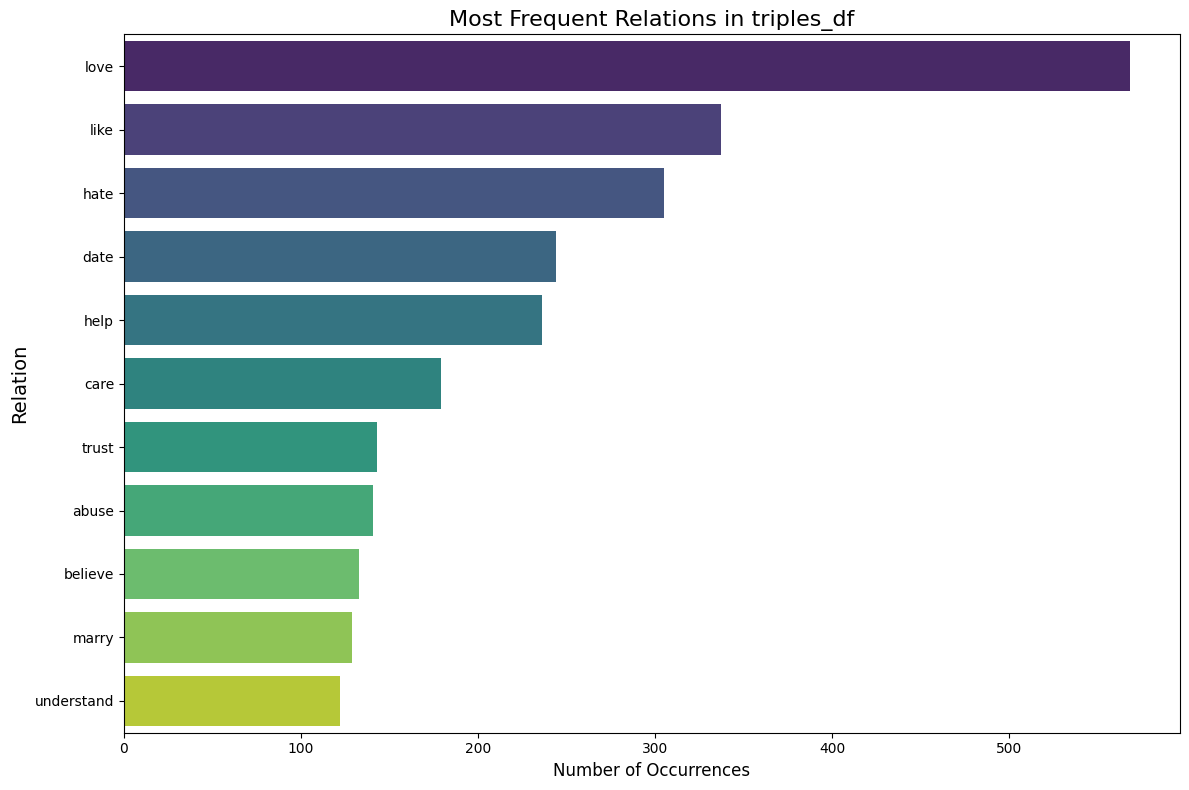

In [32]:
# Access the first element of the tuple in the 'relationship' column
relation_counts = triples_df['relationship'].apply(lambda x: x[0]).value_counts()

sorted_relation_counts = relation_counts.sort_values(ascending=False)

top_20_relations = sorted_relation_counts.head(11)

# Visualize the statistics using a horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_relations.values, y=top_20_relations.index, orient='h', palette='viridis')
plt.title('Most Frequent Relations in triples_df', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Relation', fontsize=14)
plt.tight_layout()
plt.show()

## Analyzing Extracted Triples by Coverage and Distribution

In [35]:
# Calculate the number of relationships for each row
df3["n_relationships"] = df3["relationships"].apply(len)

# No triples extracted
print("\n No triples extracted:")
display(df3[df3["n_relationships"] == 0][["text", "resolved_text"]].sample(3))

# Exactly 1 triple
print("\n Exactly 1 triple:")
display(df3[df3["n_relationships"] == 1][["text", "resolved_text", "relationships"]].sample(3))

# More than 2 triples
print("\n Multiple triples:")
display(df3[df3["n_relationships"] >= 2][["text", "resolved_text", "relationships"]].sample(3))


 No triples extracted:


,text,resolved_text
5911,What are these behaviors I get from my boyfrie...,What are these behaviors I get from my boyfrie...
4641,"My mom thinks I’m lazy, so to make me study th...","My mom thinks I’m lazy, so to make me study th..."
1529,From a teen in the US: My parents argue a lot ...,From a teen in the US: My parents argue a lot ...



 Exactly 1 triple:


,text,resolved_text,relationships
1234,My 27 year old son recently had what seems to ...,My 27 year old son recently had what seems to ...,"[{'subject': 'they', 'relation': 'accuse', 'ob..."
3925,From the U.S.: My bf and I have been together...,From the U.S.: My bf and I have been together...,"[{'subject': 'I', 'relation': 'love', 'object'..."
4040,The therapist prescribed me anti-depressants b...,The therapist prescribed me anti-depressants b...,"[{'subject': 'i', 'relation': 'believe', 'obje..."



 Multiple triples:


,text,resolved_text,relationships
1960,I have realized that the major internal proble...,I have realized that the major internal proble...,"[{'subject': 'I', 'relation': 'care', 'object'..."
5808,I’m a 15 year old girl who has been attending ...,I’m a 15 year old girl who has been attending ...,"[{'subject': 'it', 'relation': 'help', 'object..."
1570,I’ve been dating this guy for three years and ...,I’ve been dating this guy for three years and ...,"[{'subject': 'I', 'relation': 'date', 'object'..."


# Clustering Relationships by Verb Type (Using Embeddings + Clustering)

In [36]:
# Extract only unique verbs (relations) from the triples
triples_df["relation"] = triples_df["relationship"].apply(lambda x: x[0] if isinstance(x, tuple) and len(x) > 0 else None)

unique_verbs = sorted(triples_df["relation"].dropna().unique())
print(f"Found {len(unique_verbs)} unique verbs:", unique_verbs)

Found 42 unique verbs: ['abandon', 'abuse', 'accept', 'accuse', 'admire', 'avoid', 'befriend', 'believe', 'betray', 'blame', 'care', 'confide', 'connect', 'criticize', 'date', 'depend', 'despise', 'dislike', 'doubt', 'envy', 'fear', 'forgive', 'hate', 'help', 'like', 'love', 'marry', 'miss', 'neglect', 'open', 'parent', 'protect', 'raise', 'reject', 'relate', 'rely', 'resent', 'respect', 'support', 'teach', 'trust', 'understand']


In [37]:
triples_df = triples_df.rename(columns={'verb': 'relation'})
print(triples_df.head())

   id  text_id                                            context  \
0   0        1       Nobody likes me because I'm not interesting.   
1   1        9   Nobody cares about me because they didn't ask...   
2   2       10   My partner didn't say 'I love you' today our ...   
3   3       12   I didn't get a reply to my email they must ha...   
4   4       23      No one will ever love me because I'm too shy.   

         relationship relation  
0  (like, Nobody, me)     like  
1  (care, Nobody, me)     care  
2      (love, I, you)     love  
3    (hate, they, me)     hate  
4     (love, one, me)     love  


## Generating Word Embeddings

In [38]:
nlp_lg = spacy.load("en_core_web_lg")
verb_vectors = np.array([nlp_lg(verb).vector for verb in unique_verbs])

## Clustering Evaluation for Relation Verbsusing Elbow (Inertia), Silhouette Score, and Davies–Bouldin Index.

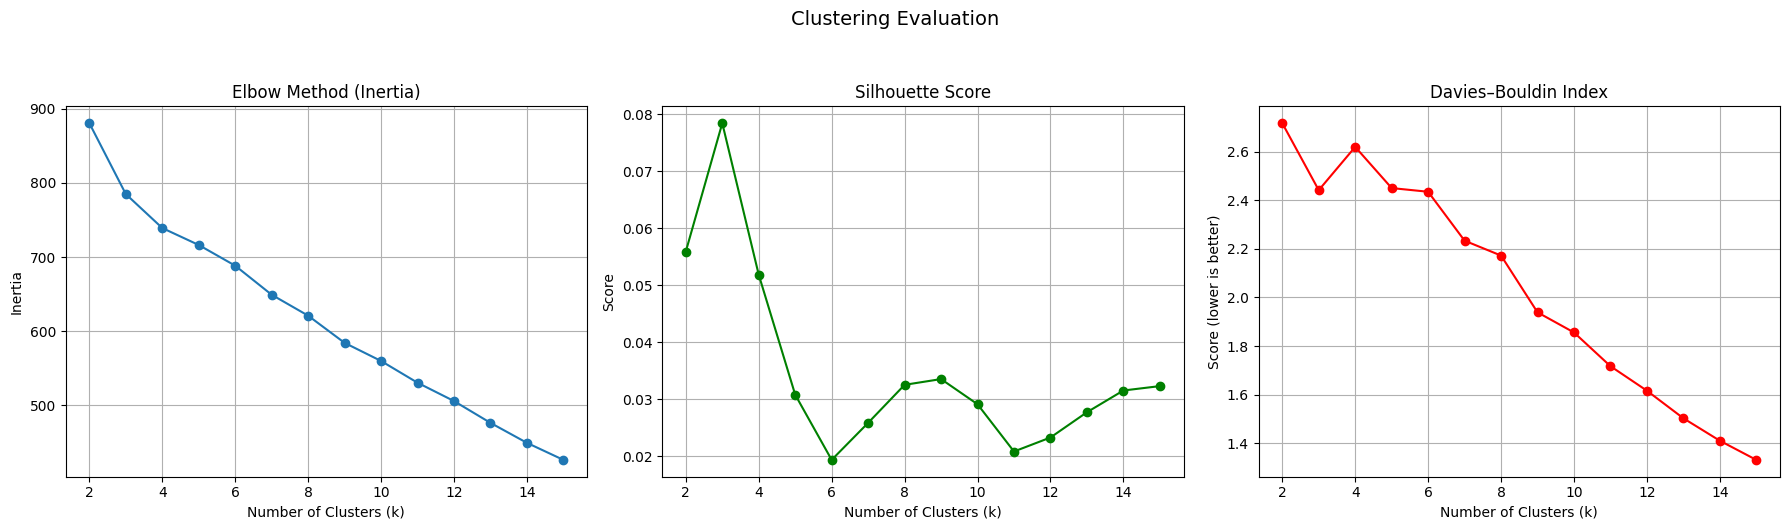

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_kmeans_clustering(vectors, k_min=2, k_max=15, random_state=42):
    """
    Evaluate KMeans clustering using Elbow (Inertia), Silhouette Score, and Davies–Bouldin Index.

    Parameters:
    - vectors (np.ndarray or pd.DataFrame): Input feature matrix (e.g., verb vectors).
    - k_min (int): Minimum number of clusters to evaluate (default=2).
    - k_max (int): Maximum number of clusters to evaluate (default=15).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - metrics_dict: Dictionary containing scores for all 3 metrics per k.
    """

    inertias = []
    silhouettes = []
    db_indices = []
    k_values = list(range(k_min, k_max + 1))

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(vectors)

        # Compute metrics
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(vectors, labels))
        db_indices.append(davies_bouldin_score(vectors, labels))

    # Plotting all three
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Elbow (Inertia)
    axes[0].plot(k_values, inertias, marker='o')
    axes[0].set_title('Elbow Method (Inertia)', fontsize=12)
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].grid(True)

    # 2. Silhouette Score
    axes[1].plot(k_values, silhouettes, marker='o', color='green')
    axes[1].set_title('Silhouette Score', fontsize=12)
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Score')
    axes[1].grid(True)

    # 3. Davies–Bouldin Index
    axes[2].plot(k_values, db_indices, marker='o', color='red')
    axes[2].set_title("Davies–Bouldin Index", fontsize=12)
    axes[2].set_xlabel("Number of Clusters (k)")
    axes[2].set_ylabel("Score (lower is better)")
    axes[2].grid(True)

    plt.suptitle("Clustering Evaluation", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    # Return raw scores for further use
    return {
        'k_values': k_values,
        'inertia': inertias,
        'silhouette': silhouettes,
        'davies_bouldin': db_indices
    }

evaluation_metrics = evaluate_kmeans_clustering(verb_vectors)

**Clustering Evaluation Summary**:
Based on Elbow, Silhouette, and Davies–Bouldin metrics, k = 3 emerges as the most interpretable and statistically reasonable number of clusters for the relation verb vectors. This setting balances compactness, separation, and model simplicity. Higher values of k yield smaller gains and may overfit to noise.

## Clustering Social Relation Verbs with KMeans (k=3)

In [40]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(verb_vectors)

# Map verbs to cluster IDs
verb_cluster_map = {verb: int(cluster) for verb, cluster in zip(unique_verbs, clusters)}

## Visualizing Clusters

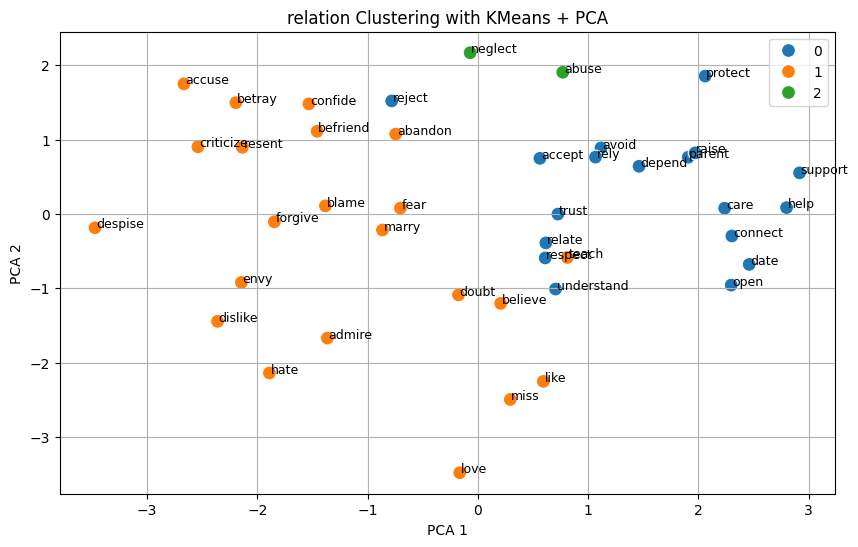

In [41]:
# Reduce dimensions for plotting
pca = PCA(n_components=2)
verb_vec_2d = pca.fit_transform(verb_vectors)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=verb_vec_2d[:, 0], y=verb_vec_2d[:, 1], hue=clusters, palette="tab10", s=100)

# Annotate points
for i, verb in enumerate(unique_verbs):
    plt.text(verb_vec_2d[i, 0] + 0.01, verb_vec_2d[i, 1], verb, fontsize=9)

plt.title("relation Clustering with KMeans + PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

### mapping each verb to it cluster and return a list of verbs to each cluster



In [42]:
cluster_to_verbs = {}
for verb, cluster_id in verb_cluster_map.items():
    if cluster_id not in cluster_to_verbs:
        cluster_to_verbs[cluster_id] = []
    cluster_to_verbs[cluster_id].append(verb)

# Print the list of verbs for each cluster
print("\nRelations assigned to each cluster:")
for cluster_id, verbs_list in cluster_to_verbs.items():
    print(f"Cluster {cluster_id}: {verbs_list}")


Relations assigned to each cluster:
Cluster 1: ['abandon', 'accuse', 'admire', 'befriend', 'believe', 'betray', 'blame', 'confide', 'criticize', 'despise', 'dislike', 'doubt', 'envy', 'fear', 'forgive', 'hate', 'like', 'love', 'marry', 'miss', 'resent', 'teach']
Cluster 2: ['abuse', 'neglect']
Cluster 0: ['accept', 'avoid', 'care', 'connect', 'date', 'depend', 'help', 'open', 'parent', 'protect', 'raise', 'reject', 'relate', 'rely', 'respect', 'support', 'trust', 'understand']


### Assign Semantic Cluster Labels to Relations




In [43]:
# Define manual labels based on cluster inspection
relation_cluster_labels = {
    0: "Supportive Actions",
    1: "Interpersonal Beliefs / Emotions",
    2: "Relational Harm"
}
# Add cluster label to each row in triples_df
triples_df["relation_cluster"] = triples_df["relation"].map(verb_cluster_map)
triples_df["relation_cluster_label"] = triples_df["relation_cluster"].map(relation_cluster_labels)

In [44]:
triples_df.head()

,id,text_id,context,relationship,relation,relation_cluster,relation_cluster_label
0,0,1,Nobody likes me because I'm not interesting.,"(like, Nobody, me)",like,1,Interpersonal Beliefs / Emotions
1,1,9,Nobody cares about me because they didn't ask...,"(care, Nobody, me)",care,0,Supportive Actions
2,2,10,My partner didn't say 'I love you' today our ...,"(love, I, you)",love,1,Interpersonal Beliefs / Emotions
3,3,12,I didn't get a reply to my email they must ha...,"(hate, they, me)",hate,1,Interpersonal Beliefs / Emotions
4,4,23,No one will ever love me because I'm too shy.,"(love, one, me)",love,1,Interpersonal Beliefs / Emotions


### Merge Distortion Labels into Triples DataFrame

In [45]:
triples_df['Dominant Distortion'] = triples_df['text_id'].map(df3.set_index('id')['Dominant Distortion'])
triples_df['Secondary Distortion (Optional)'] = triples_df['text_id'].map(df3.set_index('id')['Secondary Distortion (Optional)'])

# Display the updated triples_df
print("Triples DataFrame with Distortion columns:")
display(triples_df.head())
print(len(triples_df))

Triples DataFrame with Distortion columns:


,id,text_id,context,relationship,relation,relation_cluster,relation_cluster_label,Dominant Distortion,Secondary Distortion (Optional)
0,0,1,Nobody likes me because I'm not interesting.,"(like, Nobody, me)",like,1,Interpersonal Beliefs / Emotions,General Distortion,NaN
1,1,9,Nobody cares about me because they didn't ask...,"(care, Nobody, me)",care,0,Supportive Actions,General Distortion,NaN
2,2,10,My partner didn't say 'I love you' today our ...,"(love, I, you)",love,1,Interpersonal Beliefs / Emotions,General Distortion,NaN
3,3,12,I didn't get a reply to my email they must ha...,"(hate, they, me)",hate,1,Interpersonal Beliefs / Emotions,General Distortion,NaN
4,4,23,No one will ever love me because I'm too shy.,"(love, one, me)",love,1,Interpersonal Beliefs / Emotions,General Distortion,NaN


3307
